In [1]:
import os
import numpy as np
import torch
import copy
from torch import nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torchvision import transforms
from sklearn.model_selection import train_test_split
from collections import Counter
from torch.utils.data import TensorDataset, DataLoader
import warnings
import psutil

In [2]:
torch.cuda.is_available()

True

In [3]:
torch.cuda.get_device_name()

'NVIDIA GeForce GTX 1660 Ti'

Cuda je postavljena te možemo koristiti gpu za treniranje i testiranje mreže :)

## 1. Priprema podataka

### Korištena baza: https://www.kaggle.com/datasets/clorichel/boat-types-recognition
- napomena: zbog manjka slika određenih klasa (buoy, ferry boat, freight boat, inflatable boat, paper boat) te klase su uklonjene iz dataseta te će se provoditi klasifikacija 4 klase umjesto 9.

- U nastavku su prikazana dva načina dohvaćanja podataka, dohvaćanje iz baze je dano kao primjer, a za ovaj zadatak korišteno je dohvaćanje direktno iz datotečnog sustava.

#### Dohvaćanje podataka iz baze (postgreSQL)

- Kako nije najbolje spremati slike u bazu za potrebe ovog zadatka pohranjene su putanje do slika koje se nalaze u datotečnom sustavu. Inače bi te slike mogle biti i na cloudu te bi se također dohvaćale preko putanje.

- Baza se sastoji od jedne tablice "data" koja ima tri atributa (značajke): id, category, path

In [4]:
import psycopg2

conn = psycopg2.connect(
    database='mcoe',
    user='postgres',
    password='password',
    host='localhost',
    port='5432'
)

cursor = conn.cursor()

In [5]:
cursor.execute("SELECT path, category FROM data")
data = cursor.fetchall()
conn.close()

('C:\\Users\\David\\Desktop\\MCoE\\data\\cruise ship\\virgin-islands-cruise-ship-st-thomas-vie-949870.jpg', 'cruise ship')


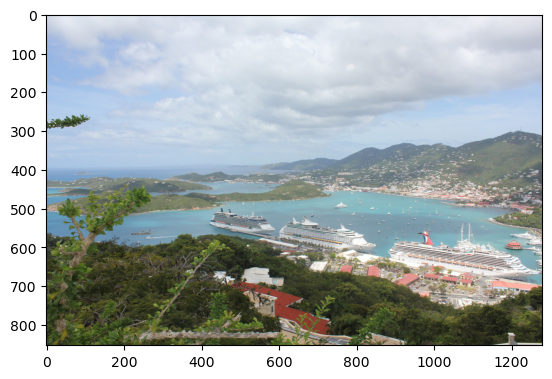

In [6]:
from matplotlib import image as mpimg

print(data[0])
image = mpimg.imread(data[0][0])
plt.imshow(image)
plt.show()

- Kao što je vidljivo, "data" je lista tuple-ova oblika (image_path, category) te se dalje ti podatci mogu lagano obraditi kako bi bili spremni za korištenje u neuronskoj mreži.

#### Dohvaćanje podataka iz datotečnog sustava

In [7]:
DATA_DIR = os.path.abspath('data')
SAVE_DIR = os.path.abspath('epochs')

In [8]:
classes = os.listdir(DATA_DIR)
num_classes = len(classes)
print(classes)

['cruise ship', 'gondola', 'kayak', 'sailboat']


In [9]:
train_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

dataset = ImageFolder(DATA_DIR, transform=train_transform)
loader = DataLoader(dataset, batch_size=len(dataset))

for image, _ in loader:
    mean = image.mean(axis=(0, 2, 3))
    std = image.std(axis=(0, 2, 3))
    
print(f'mean:{mean}\nstd:{std}')

mean:tensor([0.4810, 0.5105, 0.5250])
std:tensor([0.2839, 0.2692, 0.2946])


- Za dohvaćanje slika iz datotečnog sustava koristi se ImageFolder. Svim slikama se prilikom dohvaćanja promijeni veličina na 512x512, te se računa srednja vrijednost i standardna devijacija slika kako bi se kasnije provela normalizacija.

In [10]:
train_transform_1 = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize([0.481, 0.5105, 0.525],
                         [0.2839, 0.2692, 0.2946])
    
])

train_transform_2 = transforms.Compose([
    transforms.ColorJitter(contrast=(0.6, 0.9), saturation=(0.2, 0.6))
])

train_transform_3 = transforms.Compose([
    transforms.ColorJitter(brightness=(0.2, 0.7), contrast=(0.2, 0.6), saturation=(0.6, 0.9))
])

train_transform_4 = transforms.Compose([
    transforms.ElasticTransform(alpha=100.0)    
])

- Definirali smo tri transformacije koje ćemo napraviti nad slikama: glavnu koju ćemo primjeniti na sve slike (train_transform_1) i koja sve slike skalira na istu veličinu, pretvara ih u tenzore te ih normalizira. Ostale transformacije služe za transformiranje podataka za treniranje u svrhu dobivanja više podataka.  
<a id="color"></a>
- ColorJitter: nasumično mijenja zasićenost, svjetlinu te kontrast slike
<a id="elastic"></a>
- ElasticTransform: dodaje slici "efekt valova"

In [11]:
dataset = ImageFolder(DATA_DIR, transform=train_transform_1)
X = [image for image, _ in dataset]
y = [label for _, label in dataset]

X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, train_size=0.5, stratify=y, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, train_size=0.5, stratify=y_test_val, shuffle=True)

- Umjesto dva train_test_split može se koristiti i random_split()

In [12]:
X_train = torch.stack(X_train, 0).cuda()
X_val = torch.stack(X_val, 0).cuda()
X_test = torch.stack(X_test, 0).cuda()

X_train_augmented_1 = X_train.clone()
X_train_augmented_2 = X_train.clone()
X_train_augmented_3 = X_train.clone()

X_train_augmented_1 = torch.stack([train_transform_2(image) for image in X_train_augmented_1])
X_train_augmented_2 = torch.stack([train_transform_3(image) for image in X_train_augmented_2])
X_train_augmented_3 = torch.stack([train_transform_4(image) for image in X_train_augmented_3])

X_train = torch.cat((X_train, X_train_augmented_1, X_train_augmented_2, X_train_augmented_3))
y_train = np.concatenate((y_train, y_train, y_train, y_train))

- Kako bi povećali broj slika za treniranje napravili smo tri kopije X_train te smo na svaku primjenili drukčiju transformaciju te smo ih na kraju sve zajedno spojili u jednu varijablu X_train

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


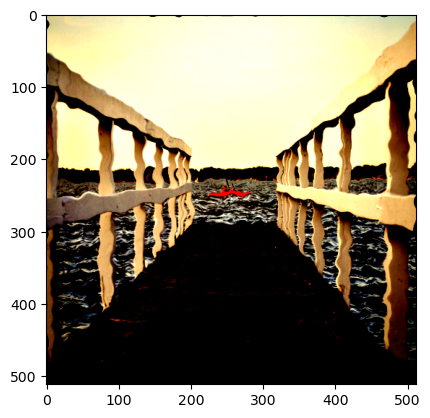

In [13]:
plt.imshow(X_train_augmented_3[0].cpu().permute(1, 2, 0))
plt.show()

In [14]:
print(f'Number of train images: {len(X_train)}\nNumber of validation images: {len(X_val)}\nNumber of test images: {len(X_test)}')

Number of train images: 2360
Number of validation images: 295
Number of test images: 295


In [15]:
print('RAM Used (GB):', psutil.virtual_memory()[3]/1000000000)

RAM Used (GB): 28.746186752


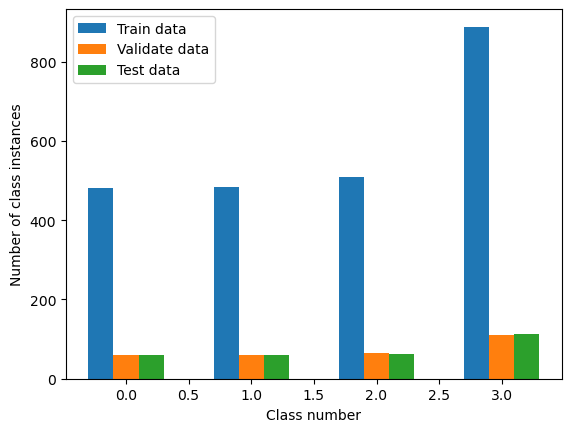

In [16]:
train_classes = dict(sorted(Counter(y_train).items()))
val_classes = dict(sorted(Counter(y_val).items()))
test_classes = dict(sorted(Counter(y_test).items()))

x = np.arange(len(list(train_classes.keys())))
y1 = list(train_classes.values())
y2 = list(val_classes.values())
y3 = list(test_classes.values())
width = 0.2

plt.bar(x-0.2, y1, width)
plt.bar(x, y2, width)
plt.bar(x+0.2, y3, width)
plt.xlabel("Class number")
plt.ylabel("Number of class instances")
plt.legend(["Train data", "Validate data", "Test data"])
plt.show()

- Kao što je vidljivo, imamo disbalans klase 3 sa ostalim klasama te i dalje imamo manjak podataka za treniranje te validaciju i testiranje no radit ćemo s onime što imamo :)

## 2. Klasifikacija

<a id="support"></a>
#### Pomoćne funkcije
- plot_progress: služi za vizualizaciju pogrešaka na skupu za treniranje i validaciju tijekom treniranja te prikaz vrijednosti padajuće stope učenja
- loss_f: funkcija gubitka, koristi se negativna log izglednost, izvod napisan na kraju 
- dense_to_one_hot: radi one-hot encoding nad klasom y kako bi se mogla koristiti za višeklasnu klasifikaciju

- Izvod funkcije gubitka:
$$L = −log(softmax(logits)_y)$$
$$= -log({e^{logits_y} \over \sum_{k=1}^{C} e^{logits_k}})$$
$$= log({\sum_{k=1}^{C} e^{logits_k}}) - logits_y$$


In [17]:
def plot_progress(data):
    fig = plt.subplots(2, 2, figsize=(16, 8))
    ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=1)
    ax2 = plt.subplot2grid((2, 2), (0, 1), colspan=1)
    ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)

    linewidth = 2
    legend_size = 10
    train_color = 'm'
    val_color = 'c'

    num_points = len(data['train_loss'])
    x_data = np.linspace(1, num_points, num_points)
    
    ax1.set_title('Cross-entropy loss')
    ax1.plot(x_data, data['train_loss'], marker='o', color=train_color,
             linewidth=linewidth, linestyle='-', label='train')
    ax1.plot(x_data, data['valid_loss'], marker='o', color=val_color,
             linewidth=linewidth, linestyle='-', label='validation')
    ax1.legend(loc='upper right', fontsize=legend_size)
    
    ax2.set_title('Average class accuracy')
    ax2.plot(x_data, data['train_acc'], marker='o', color=train_color,
             linewidth=linewidth, linestyle='-', label='train')
    ax2.plot(x_data, data['valid_acc'], marker='o', color=val_color,
             linewidth=linewidth, linestyle='-', label='validation')
    ax2.legend(loc='upper left', fontsize=legend_size)
    
    ax3.set_title('Learning rate')
    ax3.plot(x_data, data['lr'], marker='o', color=train_color,
             linewidth=linewidth, linestyle='-', label='learning_rate')
    ax3.legend(loc='upper left', fontsize=legend_size)

def loss_f(x, y):
    a = torch.log(torch.sum(torch.exp(x), dim=-1))
    b = torch.sum(y * x, dim=-1)
    L = a - b
    return torch.mean(L)

def dense_to_one_hot(y, class_count):
    return np.eye(class_count)[y]

<a id="early_stop"></a>
#### Klasa za rano zaustavljanje
- kako bi smanjili mogućnost pretreniranja i uštedjeli na vremenu, koristimo međuostalom i rano zaustavljanje. Nakon svake epohe provjeravamo je li validacijski gubitak veći od dosad najmanjeg gubitka za neku vrijednost delta te ako je, zabilježavamo. Ako se to dogodi više od "patience" puta bez da smo našli novi najmanji gubitak, prekidamo treniranje.

In [18]:
class EarlyStop:
    def __init__(self, patience=2, delta=0.3):
        self.patience = patience
        self.delta = delta
        self.best_val_loss = float('inf')
        self.patience_counter = 0
        
    def __call__(self, val_loss):
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            self.patience_counter = 0
        elif val_loss > self.best_val_loss + self.delta:
            self.patience_counter += 1
            if self.patience_counter >= self.patience:
                return True
        return False

<a id="arhitektura"></a>
#### Arhitektura mreže
- conv(16,3) -> relu() -> pool(2,2) -> conv(32,3) -> relu() -> pool(2,2) -> conv(64,3) -> relu() -> pool(2,2) -> fc(256) -> relu() -> fc(128) -> relu() -> fc(4)  
  
- Mreža se sastoji od tri konvolucijska sloja, tri sloja sažimanja, dva potpuno povezana sloja te izlaznog sloja. Kao što je vidljivo u "forward" dijelu, aktivacijska funkcija je ReLU.  
  Za veličinu kernela smo uzeli popularni 3x3 kernel te pomake 1 za prva dva sloja i pomak 2 za treći sloj. Također, prva dva sloja nadopunjujemo nulama dok treći sloj nema nadopunu kako bi malo smanjili dimenzionalnost.  
  Kako imamo dosta malo podataka za treniranje, mreža je također dosta "plitka" kako bi se smanjila mogućnost pretreniranosti i kako bi treniranje bilo manje računalno zahtjevno.  
-  reset_parameters: parametri modela se postavljaju na početne vrijednosti koje će poboljšati performanse mreže tj. pomoći stabilnosti mreže.

In [19]:
class CovolutionalModel(nn.Module):
    def __init__(self, class_count):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding='same', bias=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding='same', bias=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding='valid', bias=True)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(in_features=64*31*31, out_features=256, bias=True)
        self.fc2 = nn.Linear(in_features=256, out_features=128, bias=True)

        self.fc_logits = nn.Linear(in_features=128, out_features=class_count, bias=True)

        self.reset_parameters()

    def reset_parameters(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear) and m is not self.fc_logits:
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                nn.init.constant_(m.bias, 0)
        self.fc_logits.reset_parameters()

    def forward(self, x):
        h_1 = self.conv1(x)
        h_1 = torch.relu(h_1)
        h_1 = self.pool1(h_1)

        h_2 = self.conv2(h_1)
        h_2 = torch.relu(h_2)
        h_2 = self.pool2(h_2)
        
        h_3 = self.conv3(h_2)
        h_3 = torch.relu(h_3)
        h_3 = self.pool3(h_3)

        h_4 = h_3.reshape(h_3.shape[0], -1)

        h_4 = self.fc1(h_4)
        h_4 = torch.relu(h_4)

        h_5 = self.fc2(h_4)
        h_5 = torch.relu(h_5)

        logits = self.fc_logits(h_5)
        return logits

<a id="evaluate"></a>
#### Funkcija za validaciju/testiranje
- evaluate: prima model, dataloader te broj klasa.  
  
  model.eval() stavlja model u evaluacijski način rada (u našoj mreži nema slojeva kojima model.eval() mijenja način rada kao što su npr. slojevi normalizacije grupe ali standardni način evaluate funkcije koristi model.eval() zajedno s torch.no_grad() pa je zato tu korišten)  
  
  with torch.no_grad() govori mreži da ne računa gradijente na temelju kojih inače mijenja težine parametara modela tj. uči, a kako za vrijeme evaluacije ne želimo učiti model, računanje gradijenta treba izgasiti.  
  
  Nakon što smo isključili računanje gradijenata i postavili model u evaluacijski način rada, možemo početi s evaluacijom. Uzimamo minigrupu iz dataloadera, provedemo forward pass (model(data_x)), izračunamo gubitak (loss_f(logits, data_y)) te sačuvamo potrebne podatke za izračun srednjeg gubitka, točnosti, matrice zabune, preciznosti, odziva te f1 mjere.  
  
  Točnost: $$ACC = {broj \; točno \; klasificiranih \; slika \over ukupni \; broj \; slika}$$
  
  Matrica zabune: kvadratna matrica, retci označavaju ispravnu klasu, a stupci predviđenu klasu. Na dijagonali su "true positive" vrijednosti tj. točno označeni podatci za svaku klasu, "false positive" vrijednosti se nalaze u istom stupcu pozitivne klase, a "false negative" vrijednosti se nalaze u istom retku pozitivne klase.

  Preciznost: označava koliko dobro model predviđa pozitivnu klasu, tj. koliko slika koje su predviđene nekom klasom su upravo ta klasa.  
  $$P = {TP \over TP+FP}$$
  
  Odziv: označava koliko dobro model pozitivne primjere označava upravo kao pozitivne, tj. koliko slika neke klase su označene upravo kao ta klasa.  
  $$R = {TP \over TP+FN}$$
  
  F1 mjera: uzima u obzir i preciznost i odziv tj. označava koliko dobru preciznost i odziv model ima.  
  $$F = {2PR \over P + R}$$

In [20]:
def evaluate(model, dataloader, num_classes=4):
    model.eval()
    with torch.no_grad():
        y_true = []
        y_pred = []
        eval_loss = []

        for eval_batch in dataloader:
            data_x, data_y = eval_batch
            logits = model(data_x)
            loss = loss_f(logits, data_y)
            eval_loss.append(loss)
            y_true.append(data_y.argmax(dim=-1))
            y_pred.append(logits.argmax(dim=-1))

        eval_loss = torch.mean(torch.tensor(eval_loss))
        y_true = torch.cat(y_true)
        y_pred = torch.cat(y_pred)

        conf_matrix = torch.zeros((num_classes, num_classes), dtype=torch.int64).cuda()
        for i in range(y_true.shape[0]):
            label_true = y_true[i].item()
            label_predict = y_pred[i].item()
            conf_matrix[label_true][label_predict] += 1

        tp = torch.diag(conf_matrix)
        fp = torch.sum(conf_matrix, dim=0) - tp
        fn = torch.sum(conf_matrix, dim=1) - tp

        acc = torch.sum(tp).item() / torch.sum(conf_matrix).item()

        precision = torch.zeros(num_classes).cuda()
        recall = torch.zeros(num_classes).cuda()
        f1_score = torch.zeros(num_classes).cuda()

        for i in range(num_classes):
            if tp[i].item() + fn[i].item() != 0:
                precision[i] = tp[i].item() / (tp[i].item() + fn[i].item())
                
            if tp[i].item() + fp[i].item() != 0:
                recall[i] = tp[i].item() / (tp[i].item() + fp[i].item())
                
            if precision[i] != 0 and recall[i] != 0:
                f1_score[i] = (2 * precision[i] * recall[i]) / (precision[i] + recall[i])

    return eval_loss.item(), acc, conf_matrix, precision.cpu().numpy(), recall.cpu().numpy(), f1_score.cpu().numpy()

<a id="train"></a>
#### Funkcija za treniranje
- train: prima model, dataloader-e za trening i validaciju te broj epohi, jačinu regularizacije te stopu učenja.  
  <a id="SGD"></a>
  Kao optimizator koristimo SGD tj. stohastički gradijentni spust gdje se težine ažuriraju zasebno za svaki primjer.  
  $$w \leftarrow w - \eta\Delta_wL(logits_y, y)$$  
  popularni optimizator je i Adam koji je proširenje SGD-a te koji prilagođava stopu učenja te obično brže konvergira od SGD-a no pokazalo se da Adam (i ostale adaptivne metode) ne radi toliko dobro kod klasifikacije slika. [Referenca](https://arxiv.org/abs/1705.08292)  
  Radi primjera rada korištena je i padajuća stopa učenja (lr_scheduler) koja smanjuje stopu učenja nakon svake epohe "lr_scheduler.step()", a koristi se radi bolje konvergencije i stabilnosti tijekom treniranja.  
  Sam postupak treniranja je vrlo sličan. Najbitnija razlika je ta da ovdje radimo izračun gradijenata tj. nema "with torch.no_grad()" dijela.  
  <a id="backprop"></a>
  loss.backward() računa gradijente gubitka L po elementima parametara modela (težine, biasi...).  
  optimizer.step() primjenjuje korak optimizacije tj. ažurira parametre modela prema gornjoj formuli (u slučaju SGD-a)  
  optimizer.zero_grad() postavlja gradijente na nulu kako bi bili spremni za ponovni izračun.

In [21]:
def train(model, train_dataloader, val_dataloader, num_epochs=70, weight_decay=1e-4, lr=1e-3):
    early_stop = EarlyStop(patience=3)
    optimizer = torch.optim.SGD(model.parameters(), weight_decay=weight_decay, lr=lr)
    lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1 - 1e-4)

    plot_data = {}
    plot_data['train_loss'] = []
    plot_data['valid_loss'] = []
    plot_data['train_acc'] = []
    plot_data['valid_acc'] = []
    plot_data['lr'] = []
    best_val_loss = float('inf')
    best_epoch = 0
    
    
    for epoch in range(num_epochs):
        model.train()
        with tqdm(enumerate(train_dataloader), total=len(train_dataloader),
                  desc=f"Training (epoch={epoch + 1}/{num_epochs})") as epoch_progress:
            for batch_idx, data in epoch_progress:
                X, y = data
                logits = model(X)
                loss = loss_f(logits, y)
                
                epoch_progress.set_postfix({'train loss': loss.item()})

                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
 
        val_loss, val_acc, val_conf_matrix, val_precision, val_recall, val_f1 = evaluate(model, val_dataloader)
        train_loss, train_acc, train_conf_matrix, train_precision, train_recall, train_f1 = evaluate(model, train_dataloader)
        
        if early_stop(val_loss):
            print(f"Stopping early at epoch {epoch + 1}!")
            print(f"Best epoch is {best_epoch + 1}")
            break
        
        if val_loss < best_val_loss:
            torch.save(model.state_dict(), os.path.join(SAVE_DIR, f"best_model_epoch{epoch + 1}.pt"))
            best_val_loss = val_loss
            best_epoch = epoch
        
        print(f"Validation (epoch={epoch + 1}/{num_epochs}): loss={val_loss}, acc={val_acc}")
        if (epoch + 1) % 10 == 0:
            print(f"Confusion matrix: \n{val_conf_matrix}\nPrecision: \n{val_precision}\nRecall: \n{val_recall}\nF1 score: \n{val_f1}")

        plot_data['train_loss'] += [train_loss]
        plot_data['valid_loss'] += [val_loss]
        plot_data['train_acc'] += [train_acc]
        plot_data['valid_acc'] += [val_acc]
        plot_data['lr'] += [lr_scheduler.get_last_lr()]
        
        lr_scheduler.step()

    plot_progress(plot_data)

In [22]:
y_train = torch.from_numpy(dense_to_one_hot(y_train, num_classes)).cuda()
y_val = torch.from_numpy(dense_to_one_hot(y_val, num_classes)).cuda()
y_test = torch.from_numpy(dense_to_one_hot(y_test, num_classes)).cuda()

train_data = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)

val_data = TensorDataset(X_val, y_val)
val_dataloader = DataLoader(val_data, batch_size=16, shuffle=True)

test_data = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_data, batch_size=16, shuffle=True)

- u ovom dijelu smo pripremili podatke za korištenje na grafičkoj kartici (.cuda()) te smo iz zapakirali u dataloadere i rasporedili ih u grupe od 32\16 slika po grupi (batch_size=32\16)

Training (epoch=1/50): 100%|██████████| 74/74 [01:08<00:00,  1.07it/s, train loss=1.21] 


Validation (epoch=1/50): loss=1.2130901682001531, acc=0.4847457627118644


Training (epoch=2/50): 100%|██████████| 74/74 [01:06<00:00,  1.11it/s, train loss=1.09] 


Validation (epoch=2/50): loss=1.1999032879646525, acc=0.49830508474576274


Training (epoch=3/50): 100%|██████████| 74/74 [01:06<00:00,  1.11it/s, train loss=1.04] 


Validation (epoch=3/50): loss=1.1794556488801158, acc=0.5186440677966102


Training (epoch=4/50): 100%|██████████| 74/74 [01:06<00:00,  1.11it/s, train loss=0.927]


Validation (epoch=4/50): loss=1.1372284919077782, acc=0.5050847457627119


Training (epoch=5/50): 100%|██████████| 74/74 [01:06<00:00,  1.11it/s, train loss=0.884]


Validation (epoch=5/50): loss=1.071176605220338, acc=0.6067796610169491


Training (epoch=6/50): 100%|██████████| 74/74 [01:06<00:00,  1.11it/s, train loss=0.866]


Validation (epoch=6/50): loss=1.135897025905805, acc=0.6033898305084746


Training (epoch=7/50): 100%|██████████| 74/74 [01:00<00:00,  1.22it/s, train loss=0.602]


Validation (epoch=7/50): loss=1.2904645430494828, acc=0.5423728813559322


Training (epoch=8/50): 100%|██████████| 74/74 [01:06<00:00,  1.11it/s, train loss=0.806]


Validation (epoch=8/50): loss=1.5731994007202916, acc=0.46440677966101696


Training (epoch=9/50): 100%|██████████| 74/74 [01:06<00:00,  1.11it/s, train loss=0.826]


Validation (epoch=9/50): loss=1.176700283703219, acc=0.576271186440678


Training (epoch=10/50): 100%|██████████| 74/74 [01:06<00:00,  1.11it/s, train loss=0.291]


Validation (epoch=10/50): loss=1.1428090943353115, acc=0.5864406779661017
Confusion matrix: 
tensor([[30,  4,  6, 19],
        [ 6, 26, 10, 19],
        [ 3,  8, 33, 20],
        [11,  3, 13, 84]], device='cuda:0')
Precision: 
[0.5084746 0.4262295 0.515625  0.7567568]
Recall: 
[0.6        0.63414633 0.5322581  0.5915493 ]
F1 score: 
[0.5504587 0.5098039 0.5238096 0.6640316]


Training (epoch=11/50): 100%|██████████| 74/74 [01:06<00:00,  1.11it/s, train loss=0.753]


Validation (epoch=11/50): loss=1.3034915808497236, acc=0.5389830508474577


Training (epoch=12/50): 100%|██████████| 74/74 [01:05<00:00,  1.13it/s, train loss=0.384]


Validation (epoch=12/50): loss=1.2786806763460092, acc=0.5932203389830508


Training (epoch=13/50): 100%|██████████| 74/74 [01:07<00:00,  1.09it/s, train loss=0.683]


Validation (epoch=13/50): loss=1.3227627899278813, acc=0.5661016949152542


Training (epoch=14/50): 100%|██████████| 74/74 [01:07<00:00,  1.09it/s, train loss=0.512]


Validation (epoch=14/50): loss=1.3567272445267502, acc=0.6101694915254238


Training (epoch=15/50): 100%|██████████| 74/74 [01:07<00:00,  1.09it/s, train loss=0.414]


Validation (epoch=15/50): loss=1.3308876542528982, acc=0.5796610169491525


Training (epoch=16/50): 100%|██████████| 74/74 [01:06<00:00,  1.11it/s, train loss=0.501]


Validation (epoch=16/50): loss=1.4366631874678082, acc=0.5898305084745763


Training (epoch=17/50): 100%|██████████| 74/74 [01:06<00:00,  1.11it/s, train loss=0.638]


Stopping early at epoch 17!
Best epoch is 5


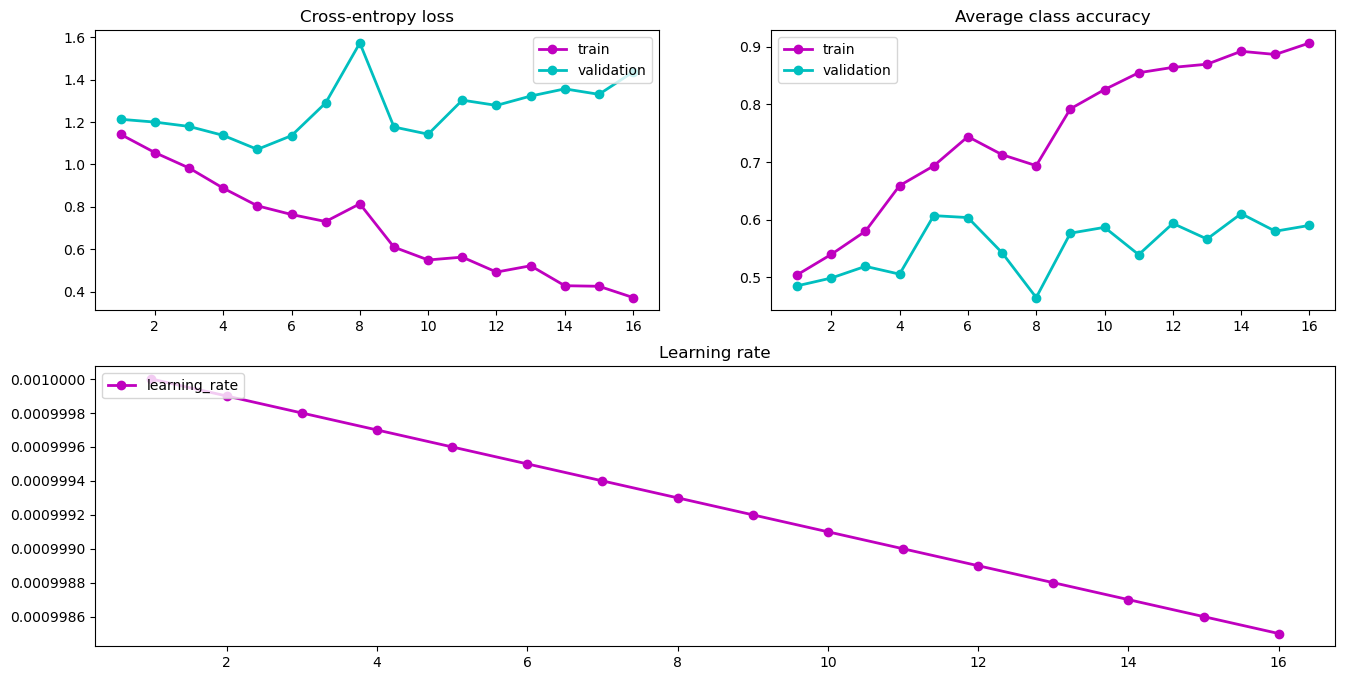

In [23]:
warnings.filterwarnings('ignore')
model = CovolutionalModel(class_count=num_classes).cuda()
train(model, train_dataloader, val_dataloader, num_epochs=50)

In [24]:
print('RAM Used (GB):', psutil.virtual_memory()[3]/1000000000)

RAM Used (GB): 26.61726208


In [27]:
model.load_state_dict(torch.load(os.path.join(SAVE_DIR, 'best_model_epoch5.pt')))
test_loss, test_acc, test_conf_matrix, test_precision, test_recall, test_f1 = evaluate(model, test_dataloader)

print(f"--- TEST ---")
print(f"loss: {test_loss}\n")
print(f"accuracy: {test_acc}\n")
print(f"Precision: \n{test_precision}\n")
print(f"Recall: \n{test_recall}\n")
print(f"F1 score: \n{test_f1}\n")
print(f"Confusion matrix: \n{test_conf_matrix}")

--- TEST ---
loss: 1.2542507254791664

accuracy: 0.5322033898305085

Precision: 
[0.6333333  0.43333334 0.20634921 0.71428573]

Recall: 
[0.44705883 0.7027027  0.3611111  0.5839416 ]

F1 score: 
[0.524138   0.5360825  0.2626263  0.64257026]

Confusion matrix: 
tensor([[38,  2,  5, 15],
        [11, 26,  8, 15],
        [16,  7, 13, 27],
        [20,  2, 10, 80]], device='cuda:0')


#### Prijedlog modela
- [Model](#arhitektura)

#### Korišteni algoritmi
- algoritam modificiranja podataka: [color jittering](#color), [elastic transform](#elastic)
- algoritam dubokog učenja: konvolucijska neuronska mreža, [backprop](#backprop)(loss.backward())
- optimizacijski algoritam: [stohastički gradijentni spust](#SGD)

#### Korištene programske komponente
- [funkcija za treniranje](#train)
- [funkcija za validaciju/testiranje](#evaluate)
- [pomoćne funkcije](#support)
- [klasa za rano zaustavljanje](#early_stop)
- PyTorch
- numpy
- CUDA
- cuDNN

#### Procjena potrebnih resursa
##### Potreban software
- PyTorch, numpy, CUDA v11.7/8 zajedno s cuDNN (za paralelizaciju i izvođenje na gpu) te ostale biblioteke (prva ćelija bilježnice)
##### Potreban hardware
- cpu: korišten AMD Ryzen 5 3600 6-Core Processor
- gpu: korišten NVIDIA GeForce GTX 1660 Ti
##### Potrebna memorija
- dataset: ~360 MB
- gpu: ~15 GB
- parametri modela: ~60 MB

In [26]:
torch.cuda.memory_allocated()

14930279424

#### Prednosti i mane u odnosu na ostala rješenja
##### Prednosti
- Kako je ova mreža vrlo mala tj. plitka, računalno je puno manje zahtjevna u odnosu na neke druge dublje mreže (npr. ResNet)
- Mreža se puno brže trenira
- Manja mogućnost pretreniranja (u našem slučaju dolazi do pretreniranja radi manjka podataka)
- Lakše podešavanje mreže: lagano se doda ili oduzme određeni sloj te se na temelju toga mreža nadograđuje
##### Mane
- Manja mreža ne može dobro naučiti kompleksnije uzorke tj. sklona je podtreniranosti
- Manja mreža nije toliko robusna i otporna na šum u podatcima
- Kako nemamo puno podataka, bolje bi bilo koristiti predtrenirane modele te ih ponovno trenirati s našim podatcima ali počevši sa parametrima koji su naučeni na većem skupu slika